In [1]:
#Adapted from https://github.com/jaimeps/adaboost-implementation/blob/master/adaboost.py for AI4SG Final Project
#Written by Kevin Lin

#Calculates the priority for the given allocation and feedback history
#Predicts future priorities using an Adaboost approach trained on given data
#Initializes with a nutritional needs matrix extracted from USDA 
#Nutrional Needs Data: https://www.ers.usda.gov/data-products/food-consumption-and-nutrient-intakes/

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_hastie_10_2
import matplotlib.pyplot as plt

In [11]:
""" HELPER FUNCTION: GET ERROR RATE ========================================="""
def get_error_rate(pred, Y):
    temp = pred != Y
    temp = temp*1
    return temp.to_numpy().sum() / float(len(Y))

""" HELPER FUNCTION: PRINT ERROR RATE ======================================="""
def print_error_rate(err):
    print ('Error rate: Training: %.4f - Test: %.4f' % err)

""" HELPER FUNCTION: GENERIC CLASSIFIER ====================================="""
def generic_clf(Y_train, X_train, Y_test, X_test, clf):
    clf.fit(X_train,Y_train)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    return get_error_rate(pred_train, Y_train), \
           get_error_rate(pred_test, Y_test)
    
""" ADABOOST IMPLEMENTATION ================================================="""
def adaboost_clf(Y_train, X_train, Y_test, X_test, M, clf):
    n_train, n_test = len(X_train), len(X_test)
    # Initialize weights
    w = np.ones(n_train) / n_train
    pred_train, pred_test = [np.zeros(n_train), np.zeros(n_test)]
    
    for i in range(M):
        # Fit a classifier with the specific weights
        clf.fit(X_train, Y_train, sample_weight = w)
        pred_train_i = clf.predict(X_train)
        pred_test_i = clf.predict(X_test)
        # Indicator function
        miss = (pred_train_i != Y_train)*1
        # Equivalent with 1/-1 to update weights
        miss2 = [x if x==1 else -1 for x in miss]
        # Error
        err_m = np.dot(w,miss) / sum(w)
        # Alpha
        alpha_m = 0.5 * np.log( (1 - err_m) / float(err_m))
        # New weights
        w = np.multiply(w, np.exp([float(x) * alpha_m for x in miss2]))
        # Add to prediction
        pred_train = [sum(x) for x in zip(pred_train, 
                                          [x * alpha_m for x in pred_train_i])]
        pred_test = [sum(x) for x in zip(pred_test, 
                                         [x * alpha_m for x in pred_test_i])]
    
    pred_train, pred_test = np.sign(pred_train), np.sign(pred_test)
    # Return error rate in train and test set
    return get_error_rate(pred_train, Y_train), \
           get_error_rate(pred_test, Y_test)

""" PLOT FUNCTION ==========================================================="""
def plot_error_rate(er_train, er_test):
    df_error = pd.DataFrame([er_train, er_test]).T
    df_error.columns = ['Training', 'Test']
    plot1 = df_error.plot(linewidth = 3, figsize = (8,6),
            color = ['lightblue', 'darkblue'], grid = True)
    plot1.set_xlabel('Number of iterations', fontsize = 12)
    plot1.set_xticklabels(range(0,450,50))
    plot1.set_ylabel('Error rate', fontsize = 12)
    plot1.set_title('Error rate vs number of iterations', fontsize = 16)
    plt.axhline(y=er_test[0], linewidth=1, color = 'red', ls = 'dashed')

In [12]:
""" MAIN SCRIPT ============================================================="""

#Read Data
df_allocation_history = pd.read_csv("./Data/allocation_history.csv")
df_feedback_history = pd.read_csv("./Data/feedback_history.csv")
df_initial_priority = pd.read_csv("./Data/nutritional_needs.csv")

#Cleaning Data 
df_allocation_history = df_allocation_history.iloc[:,:20]
df_feedback_history = df_feedback_history.iloc[3::4,:]
df_feedback_history = df_feedback_history.fillna(0)
df_feedback_history = df_feedback_history.drop(columns=['Rating'])
df_feedback_history = df_feedback_history.iloc[1:,1:].sub(df_feedback_history.mean(axis=1), axis=0)
df_feedback_history = df_feedback_history.fillna(0)
nutritional_needs = df_initial_priority.iloc[:10,:]

#Set Time and User/Item Parameters
days = 7
users = 10
df_priority = df_initial_priority
for i in range(days):
    for j in range(users):
        if i == 0 & j ==0:
            break
        else: 
            unnorm = df_priority.iloc[(i-1)*10+j,1:] + nutritional_needs.iloc[j,1:] - df_allocation_history.iloc[(i-1)*10+j,1:] - df_feedback_history.iloc[(i-1)*10+j,1:]
            unnorm = unnorm.fillna(0)
            unnorm[unnorm<0]=0
            df_priority.iloc[i*10+j,1:] = unnorm/(np.linalg.norm(unnorm))
for j in range(users):
    df_priority.iloc[j,1:] = df_priority.iloc[j,1:]/(np.linalg.norm(df_priority.iloc[j,1:]))
df_priority.to_csv("./Data/norm_priority.csv",index=False)

<ipython-input-11-bc6e4a78a32b>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot1.set_xticklabels(range(0,450,50))


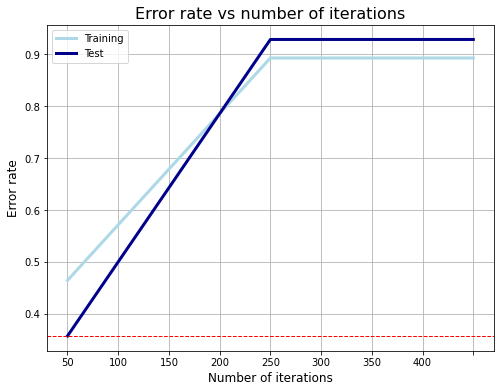

In [16]:
# Split into training and test set
df_allocation_priority = pd.read_csv("./Data/allocation_priority.csv")
df_adaboost = pd.concat([df_priority, df_allocation_priority], axis = 1)
train, test = train_test_split(df_adaboost, test_size = 0.2)
X_train, Y_train = train.iloc[:,1:-1], train.iloc[:,-1]
X_test, Y_test = test.iloc[:,1:-1], test.iloc[:,-1]
Y_train = Y_train.astype(int)
Y_test = Y_test.astype(int)
#print(Y_test)
# Fit a simple decision tree first
clf_tree = DecisionTreeClassifier(max_depth = 1, random_state = 1)
er_tree = generic_clf(Y_train, X_train, Y_test, X_test, clf_tree)

# Fit Adaboost classifier using a decision tree as base estimator
# Test with different number of iterations
er_train, er_test = [er_tree[0]], [er_tree[1]]
x_range = range(10, 30, 10)
for i in x_range:    
    er_i = adaboost_clf(Y_train, X_train, Y_test, X_test, i, clf_tree)
    er_train.append(er_i[0])
    er_test.append(er_i[1])

# Compare error rate vs number of iterations
plot_error_rate(er_train, er_test)